In [1]:
import pandas as pd
import numpy as np
from glob import glob
from path import Path
import json
import seaborn as sns
import prody
from multiprocessing import Pool
from tqdm import tqdm
import itertools
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from io import StringIO
from collections import OrderedDict, Counter
import traceback
import urllib
import pybel
from copy import deepcopy
from multiprocessing import Pool
from pymol import cmd

pd.set_option('display.max_columns', None)

from pocketdock.ligand.ligand_expo import LigandExpo
from pocketdock import utils
from pocketdock import pdb_tools

RDKit WARNING: [11:15:07] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
case_dict = utils.read_json('data/cases/4RX7_A/case.json')

In [7]:
group_dict = case_dict['ligand_groups'][0]

In [8]:
group_dict

{'name': '3YV_GOL',
 'ligands': [{'sdf_id': '4rx7_3YV_1_A_703__D___',
   'chemid': '3YV',
   'smiles': 'c1cc(cc(c1)n2nccn2)Nc3c(nnc(n3)N[C@@H]4CCCC[C@@H]4N)C(=O)N',
   'pdb_id': '4RX7',
   'pdb_chain': 'A',
   'num_heavy_atoms': 29,
   'frac_resolved': 1.0,
   'affinity': {'comp_id': '3YV',
    'type': 'IC50',
    'value': 5.0,
    'unit': 'nM',
    'provenance_code': 'Binding MOAD',
    'link': 'http://www.bindingmoad.org/pdbrecords/index/4rx7'}},
  {'sdf_id': '4rx7_GOL_1_A_702__C___',
   'chemid': 'GOL',
   'smiles': 'C(C(CO)O)O',
   'pdb_id': '4RX7',
   'pdb_chain': 'A',
   'num_heavy_atoms': 6,
   'frac_resolved': 1.0,
   'affinity': None}],
 'domain_aligment': {'interacting_domains': [0, 1],
  'pdb_resi_ranges': [[363, 450], [451, 635]],
  'af_resi_ranges': [[363, 450], [451, 635]],
  'af_aln': 'VYLDRKLLTLEDKELGSGNFGTVKKGYYQMKKVVKTVAVKILKNEANDPALKDELLAEANVMQQLDNPYIVRMIGICEAESWMLVMEMAELGPLNKYLQQNRHVKDKNIIELVHQVSMGMKYLEESNFVHRDLAARNVLLVTQHYAKISDFGLSKALRADENYYKAQTHGKWPVKWYAPECINYYKFS

In [10]:
chemid_to_matches = utils.read_json('data/chemid_to_matches.json')

In [11]:
chemid_to_matches['3YV']

{'01P': {'ref_chemid': '01P',
  'ref_smiles': 'COc1cc(ccc1N2CCOCC2)Nc3nccc(n3)Nc4cc5ccccc5nc4',
  'mcs_flags': ['r'],
  'fp_tanimoto': 0.3416974169741697,
  'mcs_tar_coverage': 0.6551724137931034,
  'mcs_ref_coverage': 0.59375,
  'mcs_tanimoto': 0.4523809523809524,
  'mcs_smarts': '[#6&R](:&@[#6&R]:&@[#6&R](:&@[#6&R])-&!@[#7&!R]-&!@[#6&R](:&@[#6&R]):&@[#7&R]:&@[#6&R](:&@[#7&R])-&!@[#7&!R]-&!@[#6&R]1-,:;@[#6&R]-,:;@[#6&R]-,:;@[#6&R]-,:;@[#6&R]-,:;@[#6&R]-,:;@1):&@[#6&R]:&@[#6&R]',
  'mcs_num_atoms': 19,
  'mcs_num_bonds': 19},
 '02Z': {'ref_chemid': '02Z',
  'ref_smiles': 'c1ccc(cc1)Nc2nc(c(s2)C(=O)N)N',
  'mcs_flags': ['r'],
  'fp_tanimoto': 0.44653349001175086,
  'mcs_tar_coverage': 0.5172413793103449,
  'mcs_ref_coverage': 0.9375,
  'mcs_tanimoto': 0.5,
  'mcs_smarts': '[#6&R]1:,-;@[#6&R]:,-;@[#6&R]:,-;@[#6&R](:,-;@[#6&R]:,-;@[#6&R]:,-;@1)-&!@[#7&!R]-&!@[#6&R]:&@[#7&R]:&@[#6&R](:&@[#6&R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#7&!R])-&!@[#7&!R]',
  'mcs_num_atoms': 15,
  'mcs_num_bonds': 15},
 

In [12]:
cases = OrderedDict((x.dirname().basename(), utils.read_json(x)) for x in tqdm(sorted(Path('data/cases').glob('*/case.json'))))


100%|██████████| 20562/20562 [01:22<00:00, 249.84it/s] 


In [33]:
case_dict['case_name']

'4RX7_A'

In [36]:
frag_templates = []
for lig_id, lig in enumerate(group_dict['ligands']):
    sim_ligs = chemid_to_matches[lig['chemid']]
    for sim_chemid, sim_dict in sim_ligs.items():
        pdbs = LigandExpo.get_pdb_list(sim_chemid)
        #print(lig['chemid'], sim_chemid, pdbs)
        for pdb in pdbs:
            chains = [x for x in cases.keys() if x[:4] == pdb]
            for chain in chains:
                if chain == case_dict['case_name']:
                    continue
                chain_dict = cases[chain]
                for sim_id, sim_group in enumerate(chain_dict['ligand_groups']):
                    if sim_chemid in sim_group['name']:
                        for sim_lig_id, sim_lig_dict in enumerate(sim_group['ligands']):
                            if sim_chemid == sim_lig_dict['chemid']:
                                break
                        frag_templates.append({
                            'tar_chemid': lig['chemid'],
                            'tar_smiles': lig['smiles'],
                            'tar_lig_id': lig_id,
                            'tpl_chain': chain,
                            'tpl_group': sim_group['name'],
                            'tpl_group_id': sim_id,
                            'tpl_chemid': sim_chemid,
                            'tpl_lig_id': sim_lig_id,
                            'match': sim_dict
                        })

In [37]:
len(frag_templates)

8

In [41]:
Path('data/train_split').mkdir_p()

debug_case = {
    'case_name': case_dict['case_name'],
    'group_name': group_dict['name'],
    'fragment_templates': frag_templates,
    'hhpred_templates': []
}

utils.write_json([debug_case], 'data/train_split/debug.json')

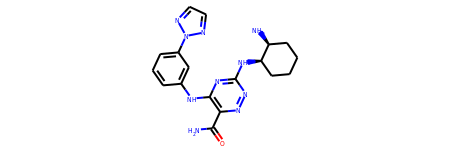

In [23]:
Chem.MolFromSmiles('c1cc(cc(c1)n2nccn2)Nc3c(nnc(n3)N[C@@H]4CCCC[C@@H]4N)C(=O)N')

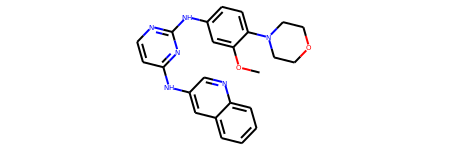

In [24]:
Chem.MolFromSmiles('COc1cc(ccc1N2CCOCC2)Nc3nccc(n3)Nc4cc5ccccc5nc4')